<a href="https://colab.research.google.com/github/rvi077344/Detection_and_estimation_deepIM-OFDM-IM_Final_project/blob/master/ofdmDeepIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 17kB/s 
     |████████████████████████████████| 3.8MB 38.8MB/s 
     |████████████████████████████████| 512kB 50.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=8c153782bd35bc93d343dccc655d2ae3286a6bd92737b5cccbf40ea1cfc62769
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling te

In [2]:
import numpy as np
import tensorflow as tf
import scipy
from scipy.special import binom
print(scipy.__version__)
print(tf.__version__)
print(np.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

1.4.1
1.15.0
1.18.4
Found GPU at: /device:GPU:0


In [3]:
N = 4 # number of sub-carriers
K = 1 # number of active sub-carriers
M = 4 # M-ary modulation order
SNRdb = 10 # Training SNR

traing_epochs = 1000
l_rate = 0.001 
total_batch = 20 # number of batches per epoch
batch_size = 1000

n_hidden_1 = 32 # smaller for Tanh, larger for ReLu
n_input = 3*N

m = int(np.log2(M))
c = int(np.log2(binom(N,K)))
q = K*m + c # number of bits per OFDM-IM symbol
print('Output number of the system: ',q)
Q = 2**q
n_output = q
display_step = 10
SNR = 10**(SNRdb/10)
sigma = np.sqrt(1/SNR)
qam_factor = (2/3)*(M-1)

bits = np.random.binomial(n=1, p=0.5, size = (q,))
a = 1/np.sqrt(2)

Output number of the system:  4


In [4]:
# M-ary modulations
if M==4:
    QAM = np.array([1+1j, 1-1j, -1+1j, -1-1j], dtype=complex) # gray mapping
elif M==8:
    QAM = np.array([1, a+a*1j, -a+a*1j, 1j, a-a*1j, -1j, -1, -a-a*1j], dtype=complex) # 8PSK, not 8QAM indeed
    qam_factor = 1
elif M==16:
    QAM = np.array([-3+3j, -3+1j, -3-3j, -3-1j, -1+3j, -1+1j, -1-3j, -1-1j, 3+3j, 3+1j, 3-3j, 3-1j, 1+3j, 1+1j, 1-3j, 1-1j], dtype=complex)
else:
    QAM = np.array([1, -1], dtype=complex) #BPSK
    qam_factor = 1

print("QAM number is ",M,".")
print("QAM factor is ",qam_factor,".")
power = np.sqrt(N/K/qam_factor) # power allocation factor

# index patterns for N=4 and K=1,2,3 only
if K==1:
    idx = np.array([[0],[1],[2],[3]])
elif K==2:
    idx = np.array([[0,1],[2,3],[0,2],[1,3]]) 
else:
    idx = np.array([[0,1,2],[1,2,3],[0,2,3],[0,1,3]]) 

QAM number is  4 .
QAM factor is  2.0 .


In [5]:
def OFDM_IM_received(bits, SNRdb):   
    bit_id = bits[0:c:1]
    id_de = bit_id.dot(2**np.arange(bit_id.size)[::-1])
    
    bit_sy = bits[c:q:1]   
    bit_K = bit_sy.reshape(-1,m)
    sy_de = np.zeros((K,), dtype=int)
    sym = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i = bit_K[i,:]
        sy_de[i] = bit_sy_i.dot(2**np.arange(bit_sy_i.size)[::-1])
        sym[i] = QAM[sy_de[i]]

    tx_sym = np.zeros((N,), dtype=complex)
    tx_sym[idx[id_de,:]] = sym
    tx_sym = tx_sym*power
    
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    #eps = 1./(1 + SNR) # imperfect CSI
    eps = 0.0
    
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym.shape)+1j*np.random.randn(*tx_sym.shape))
    h = np.sqrt((1-eps)/2)*(np.random.randn(*tx_sym.shape)+1j*np.random.randn(*tx_sym.shape))
    e = np.sqrt(eps/2)*(np.random.randn(*tx_sym.shape)+1j*np.random.randn(*tx_sym.shape))
    h1 = h + e
    
    y = h1*tx_sym + noise
    y_bar = y/h
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y)
    Y = np.concatenate((y_con,y_m))

    return Y  

print("OFDM received defination.")

OFDM received defination.


In [6]:
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    weights = {                    
        'encoder_h1': tf.Variable(initializer([n_input, n_hidden_1])),
        'encoder_h2': tf.Variable(initializer([n_hidden_1, n_output])),            
    }
    biases = {            
        'encoder_b1': tf.Variable(initializer([n_hidden_1])),
        'encoder_b2': tf.Variable(initializer([n_output])),          
    
    }
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

y_pred = encoder(X)
y_true = Y

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) #cost function
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

print("Network Structure is defined.")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Network Structure is defined.


In [7]:
# Training and testing phases 
with tf.Session() as sess:
    # Training
    print("----------Start to train the network.----------")
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0.
        for index_m in range(total_batch):
            input_samples = []
            input_labels = []
            for index_k in range(0, batch_size):
                bits = np.random.binomial(n=1, p=0.5, size=(q,))
                signal_output = OFDM_IM_received(bits, SNRdb)  
                input_labels.append(bits)
                input_samples.append(signal_output)
 
            batch_x = np.asarray(input_samples)
            batch_y = np.asarray(input_labels)
            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_x, Y:batch_y,learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("----------End training process.----------")    
    # Testing            
    EbNodB_range = list(frange(0,35,5)) # 0dB - 30dB
    ber = [None]*len(EbNodB_range)
    print("----------Start the test process.----------")
    for n in range(0,len(EbNodB_range)):
        input_samples_test = []
        input_labels_test = []
        test_number = 100000
        if n>10:
            test_number = 1000000
        for i in range(0, test_number):
            bits = np.random.binomial(n=1, p=0.5, size=(q, )) 
            signal_output = OFDM_IM_received(bits, EbNodB_range[n])
            input_labels_test.append(bits)
            input_samples_test.append(signal_output)
            
        batch_x = np.asarray(input_samples_test) #Convert the input to an array.
        batch_y = np.asarray(input_labels_test)
        
        #print('Predicted y is ', sess.run(tf.sign(y_pred-0.5), feed_dict = {X:batch_x}))
        #print('Batch_y is \n', sess.run(tf.cast(tf.sign(batch_y-0.5),tf.float32)))
        mean_error = tf.reduce_mean(abs(y_pred - batch_y)) # mean_error.eval({X:batch_x}),
        mean_error_rate = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_y-0.5),tf.float32))),1))
        ber[n]  = mean_error_rate.eval({X:batch_x}) # eval
        print("SNR=", EbNodB_range[n], "BER:", ber[n])

----------Start to train the network.----------
Epoch: 0001 cost= 0.259478929
Epoch: 0011 cost= 0.072973894
Epoch: 0021 cost= 0.046226173
Epoch: 0031 cost= 0.038294888
Epoch: 0041 cost= 0.034708731
Epoch: 0051 cost= 0.031334844
Epoch: 0061 cost= 0.027774575
Epoch: 0071 cost= 0.027383755
Epoch: 0081 cost= 0.026226513
Epoch: 0091 cost= 0.023445486
Epoch: 0101 cost= 0.023355383
Epoch: 0111 cost= 0.022417694
Epoch: 0121 cost= 0.021876004
Epoch: 0131 cost= 0.021173872
Epoch: 0141 cost= 0.020353682
Epoch: 0151 cost= 0.019999791
Epoch: 0161 cost= 0.019808198
Epoch: 0171 cost= 0.018979256
Epoch: 0181 cost= 0.018274760
Epoch: 0191 cost= 0.018374136
Epoch: 0201 cost= 0.017610097
Epoch: 0211 cost= 0.017382765
Epoch: 0221 cost= 0.018041246
Epoch: 0231 cost= 0.017413198
Epoch: 0241 cost= 0.017653008
Epoch: 0251 cost= 0.016773965
Epoch: 0261 cost= 0.017386012
Epoch: 0271 cost= 0.016142351
Epoch: 0281 cost= 0.016521363
Epoch: 0291 cost= 0.016570398
Epoch: 0301 cost= 0.015380387
Epoch: 0311 cost= 0.01

In [8]:
# BPSK AWGN channel BER performance
from numpy import sqrt
from numpy.random import rand, randn
  
N = 5000000
EbNodB_range = range(0,35,5)
itr = len(EbNodB_range)
ber2 = [None]*itr

for n in range (0, itr): 
 
    EbNodB = EbNodB_range[n]   
    EbNo=10.0**(EbNodB/10.0)
    x = 2 * (rand(N) >= 0.5) - 1
    noise_std = 1/sqrt(2*EbNo)
    y = x + noise_std * randn(N)
    y_d = 2 * (y >= 0) - 1
    errors = (x != y_d).sum()
    ber2[n] = 1.0 * errors / N
    
    print("EbNodB:", EbNodB)
    #print("Error bits:", errors)
    print("Error probability:", ber[n]) 

EbNodB: 0
Error probability: 0.19639999
EbNodB: 5
Error probability: 0.06813753
EbNodB: 10
Error probability: 0.017244995
EbNodB: 15
Error probability: 0.0038300157
EbNodB: 20
Error probability: 0.00094747543
EbNodB: 25
Error probability: 0.00031501055
EbNodB: 30
Error probability: 0.00013500452


In [9]:
# ML detectors
ber3 = np.array([0.226491,0.103562,0.0369861,0.00980914,0.00213404,4.001810e-004,9.612538e-005])
# LLR detectors
ber4 = np.array([0.289978,0.144974,0.0512481,0.0141429,0.00320167,5.384964e-004,1.000000e-004])

print(ber)
# print(ber2)
print(ber3)
print(ber4)

[0.19639999, 0.06813753, 0.017244995, 0.0038300157, 0.00094747543, 0.00031501055, 0.00013500452]
[2.264910e-01 1.035620e-01 3.698610e-02 9.809140e-03 2.134040e-03
 4.001810e-04 9.612538e-05]
[2.899780e-01 1.449740e-01 5.124810e-02 1.414290e-02 3.201670e-03
 5.384964e-04 1.000000e-04]


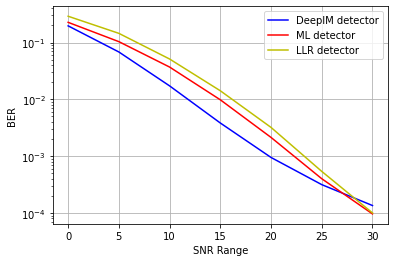

In [10]:
import matplotlib.pyplot as plt
plt.plot(EbNodB_range,ber,'b',label='DeepIM detector')
plt.plot(EbNodB_range,ber3,'r',label='ML detector')
plt.plot(EbNodB_range,ber4,'y',label='LLR detector')
# plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('BER')
plt.legend(loc='upper right',ncol = 1)
plt.grid()
#plt.savefig('DL_Detection_IM_BER_matplotlib')
plt.show()